# Обучение с учителем
____

## Описание проекта
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)
____

## Описание данных
**Признаки**
* **`RowNumber`** — индекс строки в данных;
* **`CustomerId`** — уникальный идентификатор клиента;
* **`Surname`** — фамилия;
* **`CreditScore`** — кредитный рейтинг;
* **`Geography`** — страна проживания;
* **`Gender`** — пол;
* **`Age`** — возраст;
* **`Tenure`** — количество недвижимости у клиента;
* **`Balance`** — баланс на счёте;
* **`NumOfProducts`** — количество продуктов банка, используемых клиентом;
* **`HasCrCard`** — наличие кредитной карты;
* **`IsActiveMember`** — активность клиента;
* **`EstimatedSalary`** — предполагаемая зарплата;

**Целевой признак**
* **`Exited`** — факт ухода клиента;
_____

## Структура проекта
<a href='#section1'></a>
1. [Подготовка данных](#section1)
<a href='#section2'></a>
2. [Исследование задачи](#section2)
<a href='#section3'></a>
3. [Борьба с дисбалансом](#section3)
<a href='#section4'></a>
4. [Тестирование модели](#section4)
<a href='#section5'></a>
5. [Выводы исследования](#section5)
___
___

<a id='section1'></a>
## 1. Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import warnings 
# Модели
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
# Интструменты
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
from tqdm import tqdm
# Графики
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Заменим все `NaN` в `Tenure` на 0. 

In [5]:
data['Tenure'] = data['Tenure'].fillna(0)
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Избавимся от лишний столбцов: `RowNumber`, `CustomerId`, `Surname`. 
Первый дублирует dataframe.index, второй и третий не несут никакой роли, т.к. нет влияния фамилии и кодового номера на желание клиента оставаться таковым.

In [6]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Преобразуем категориальные признаки (`Geography`, `Gender`) в количественные методом прямого кодирования.

In [8]:
print('Geography unique values:', data['Geography'].unique())
print('Gender unique values:', data['Gender'].unique())

Geography unique values: ['France' 'Spain' 'Germany']
Gender unique values: ['Female' 'Male']


In [9]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null float64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


**Выводы:**
1. Строки со значениями `Nan` в столбце `Tenure` были классифицированы как отсутствие недвижимости у клиента и заполнены нулями;
2. Удалены столбцы `RowNumber`, `CustomerId`, `Surname`, т.к. не несут информации для построения модели классификации по поставленной задаче;
3. Оставшиеся категориальные признаки были переведены в количественные по средствам метода прямого кодирования с защитой от дамми-ловушки.
____

<a id='section2'></a>
## 2. Исследование задачи

1. Произведём разбиение данных на обучающую, валидационную и тестовую выборки;
2. Изучим на наличие дисбаланса классов. 
3. Обучим следующий перечень моделей (без учёта дисбаланса классов):
    * Логистическая регрессия;
    * Дерево решений;
    * Случайный лес;
    * Наивный байес.
4. Посчитаем метрики:
    * Точность попадения в класс;
    * Точность;
    * Полнота;
    * F1-мера;
5. Построим ROC-кривую и посчитаем AUC-ROC.
____

Будем производить разбиение в долях: $60$% / $20$% / $20$%.

In [10]:
def train_valid_test_split(df : pd.DataFrame, proportions=[0.6, 0.2, 0.2]):
    """
        Function splits by train, validation, test parts income dataframe.
        In:
            df : pandas.DataFrame() - income dataframe.
            proportions : list() - list of proportions values to split method.
    """
    if sum([*proportions]) != 1:
        raise AttributeError('Wrong "proportions" values. Sum of "proportions" values > 1.0. Must be equal to 1.0.')
    data_list = [train, valid, test] = np.split(
        df.sample(frac=1, random_state=271828), 
        [int(proportions[0]*len(df)), int(sum(proportions[:2])*len(df))]
    )
    features, targets = list(), list()
    for data in data_list:
        features.append(data.drop('Exited', axis=1))
        targets.append(data['Exited'])
    return [*features, *targets]

In [11]:
features_train, features_valid, features_test, target_train, target_valid, target_test = \
    train_valid_test_split(data_ohe, proportions=[0.6, 0.2, 0.2])

In [12]:
table = [
    ['Sample', 'Features_m', 'Features_n', 'Target'],
    ['Train', *features_train.shape, *target_train.shape],
    ['Valid', *features_valid.shape, *target_valid.shape],
    ['Test', *features_test.shape, *target_test.shape]
]

def print_table(table):
    longest_cols = [
        (max([len(str(row[i])) for row in table]) + 3)
        for i in range(len(table[0]))
    ]
    row_format = "".join(["{:>" + str(longest_col) + "}" for longest_col in longest_cols])
    for row in table:
        print(row_format.format(*row))

In [13]:
print_table(table)

   Sample   Features_m   Features_n   Target
    Train         6000           11     6000
    Valid         2000           11     2000
     Test         2000           11     2000


Посмотрим на дисбаланс классов.

In [14]:
exited_value_counts = data_ohe['Exited'].value_counts()
print('Распределение классов порядка 1 к {:.0f}.'.format(exited_value_counts[0] / exited_value_counts[1]))

Распределение классов порядка 1 к 4.


**Логистическая регрессия**

In [15]:
%%time

logreg = LogisticRegression(random_state=271828, solver='liblinear')
logreg.fit(features_train, target_train)
predicted_valid = logreg.predict(features_valid)
print('F1-мера =', f1_score(target_valid, predicted_valid))

F1-мера = 0.07505518763796908
Wall time: 21.9 ms


**Дерево решений**

In [16]:
%%time

best_depth, best_f1 = 0, 0
for depth in range(1, 21):
    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=271828)
    tree_clf.fit(features_train, target_train)
    predicted_valid = tree_clf.predict(features_valid)
    tmp_f1 = f1_score(target_valid, predicted_valid)
    if best_f1 < tmp_f1:
        best_f1 = tmp_f1
        best_depth = depth
        print('max_depth = %s | F1-мера ='%best_depth, best_f1)
tree_clf = DecisionTreeClassifier(max_depth=best_depth, random_state=271828)
tree_clf.fit(features_train, target_train)
tree_clf

max_depth = 2 | F1-мера = 0.5150602409638554
max_depth = 3 | F1-мера = 0.5333333333333333
max_depth = 5 | F1-мера = 0.5606060606060606
max_depth = 6 | F1-мера = 0.5869262865090403
Wall time: 388 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=271828, splitter='best')

**Случайный лес**

In [17]:
%%time

best_est, best_depth, best_f1 = 0, 0, 0
for est in range(10, 120, 20):
    for depth in range(1, 21):
        rf_clf = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=271828)
        rf_clf.fit(features_train, target_train)
        predicted_valid = rf_clf.predict(features_valid)
        tmp_f1 = f1_score(target_valid, predicted_valid)
        if best_f1 < tmp_f1:
            best_est = est
            best_depth = depth
            best_f1 = tmp_f1
            print('n_estimators = %s | max_depth = %s | F1-мера ='%(best_est, best_depth), best_f1)

n_estimators = 10 | max_depth = 1 | F1-мера = 0.004878048780487805
n_estimators = 10 | max_depth = 2 | F1-мера = 0.189010989010989
n_estimators = 10 | max_depth = 3 | F1-мера = 0.24255319148936175
n_estimators = 10 | max_depth = 4 | F1-мера = 0.5114754098360655
n_estimators = 10 | max_depth = 5 | F1-мера = 0.5228758169934642
n_estimators = 10 | max_depth = 6 | F1-мера = 0.5384615384615384
n_estimators = 10 | max_depth = 7 | F1-мера = 0.5434083601286173
n_estimators = 10 | max_depth = 8 | F1-мера = 0.5434782608695652
n_estimators = 10 | max_depth = 9 | F1-мера = 0.5522620904836193
n_estimators = 10 | max_depth = 10 | F1-мера = 0.5623100303951367
n_estimators = 10 | max_depth = 13 | F1-мера = 0.5647743813682679
n_estimators = 10 | max_depth = 16 | F1-мера = 0.5697841726618705
n_estimators = 30 | max_depth = 12 | F1-мера = 0.5714285714285714
n_estimators = 30 | max_depth = 14 | F1-мера = 0.5820895522388059
n_estimators = 30 | max_depth = 18 | F1-мера = 0.5897810218978102
Wall time: 26.7 s

In [18]:
%%time

# Детальнее в диапазоне 20-40.
best_est, best_depth, best_f1 = 0, 0, 0
for est in range(20, 41):
    for depth in range(1, 21):
        rf_clf = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=271828)
        rf_clf.fit(features_train, target_train)
        predicted_valid = rf_clf.predict(features_valid)
        tmp_f1 = f1_score(target_valid, predicted_valid)
        if best_f1 < tmp_f1:
            best_est = est
            best_depth = depth
            best_f1 = tmp_f1
            print('n_estimators = %s | max_depth = %s | F1-мера ='%(best_est, best_depth), best_f1)
rf_clf = RandomForestClassifier(n_estimators=best_est, max_depth=best_depth, random_state=271828)
rf_clf.fit(features_train, target_train)
rf_clf

n_estimators = 20 | max_depth = 2 | F1-мера = 0.1324200913242009
n_estimators = 20 | max_depth = 3 | F1-мера = 0.20824295010845986
n_estimators = 20 | max_depth = 4 | F1-мера = 0.4672566371681416
n_estimators = 20 | max_depth = 5 | F1-мера = 0.4957555178268251
n_estimators = 20 | max_depth = 6 | F1-мера = 0.5307443365695793
n_estimators = 20 | max_depth = 8 | F1-мера = 0.5607476635514018
n_estimators = 20 | max_depth = 10 | F1-мера = 0.5625965996908809
n_estimators = 20 | max_depth = 12 | F1-мера = 0.5709969788519638
n_estimators = 20 | max_depth = 14 | F1-мера = 0.576923076923077
n_estimators = 20 | max_depth = 20 | F1-мера = 0.5817091454272864
n_estimators = 21 | max_depth = 18 | F1-мера = 0.5844346549192364
n_estimators = 21 | max_depth = 20 | F1-мера = 0.5887573964497042
n_estimators = 23 | max_depth = 10 | F1-мера = 0.5893129770992367
n_estimators = 23 | max_depth = 20 | F1-мера = 0.5903083700440528
Wall time: 47.9 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=23,
                       n_jobs=None, oob_score=False, random_state=271828,
                       verbose=0, warm_start=False)

**Наивный байес**

In [19]:
bayes = GaussianNB()
bayes.fit(features_train, target_train)
predicted_valid = bayes.predict(features_valid)
print('F1-мера =', f1_score(target_valid, predicted_valid))

F1-мера = 0.12790697674418605


Подведём итоги в таблице.

In [20]:
def get_model_metrics(model, features=features_valid, target=target_valid):
    '''
        Returns model`s metrics & characteristics of ROC-curve:
            1) accuracy;
            2) precision;
            3) recall;
            4) f1;
            5) auc_roc;
    '''
    accuracy = accuracy_score(target, model.predict(features))
    precision = precision_score(target, model.predict(features))
    recall = recall_score(target, model.predict(features))
    f1 = f1_score(target, model.predict(features))
    probabilities_one = model.predict_proba(features)[:, 1]
    auc_roc = roc_auc_score(target, probabilities_one)
    
    return np.round(accuracy, 4), np.round(precision, 4), np.round(recall, 4), np.round(f1, 4), np.round(auc_roc, 4)

In [21]:
table = [
    [
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC'
    ],
    [
        'LogisticRegression', *get_model_metrics(logreg)
    ],
    [
        'DecisionTreeClassifier', *get_model_metrics(tree_clf)
    ],
    [
        'RandomForestClassifier', *get_model_metrics(rf_clf)
    ],
    [
        'GaussianNB', *get_model_metrics(bayes)
    ],
]

In [22]:
print_table(table)

                    Model   Accuracy   Precision   Recall       F1   AUC-ROC
       LogisticRegression     0.7905      0.3864   0.0416   0.0751    0.6668
   DecisionTreeClassifier     0.8515      0.6806   0.5159   0.5869    0.8439
   RandomForestClassifier     0.8605       0.739   0.4914   0.5903    0.8535
               GaussianNB      0.775      0.3084   0.0807   0.1279    0.7457


In [23]:
def plot_roc_curves():
    '''
        Plots ROC-curves for all trained models & calculates AUC-ROC value.
    '''
    plt.figure(figsize=[12, 12])
    plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--', label='Random Model' + ' --- ' + str(0.5))
    models_dict = {
        'LogisticRegression' : logreg, 
        'DecisionTreeClassifier' : tree_clf,
        'RandomForestClassifier' : rf_clf, 
        'GaussianNB' : bayes
    }
    for name, model in models_dict.items():
        probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
        fpr, tpr, threshold = roc_curve(target_valid, probabilities_one_valid)
        auc_roc = np.round(roc_auc_score(target_valid, probabilities_one_valid), 5)
        plt.plot(fpr, tpr, label=name + ' --- ' + str(auc_roc))
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc=4, fontsize=14)
    plt.grid()
    plt.title('ROC-curve', fontsize=20)
    plt.show()

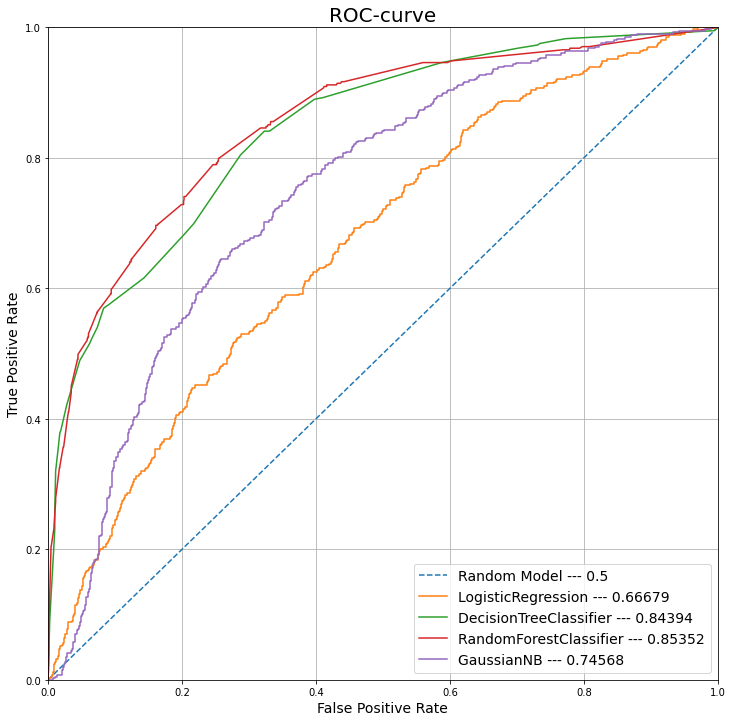

In [24]:
plot_roc_curves()

**Результаты:**
1. Лучшие метрики по $F1$-мере и $AUC-ROC$ получены у модели `Случайного леса`.
2. Все обученные модели, вследствие дисбаланса классов, имеют меньшие значения по полноте относительно точности. 
3. В данных есть дисбаланс классов в соотношении порядка $1$ к $4$.
____

<a id='section3'></a>
## 3. Борьба с дисбалансом

Исправлять дисбаланс классов будем тремя методами:
* Взвешенными классами в моделях `sklearn`;
* `Upsampling`;
* `Downsampling`.

**`class_weight = 'balanced'`**

In [25]:
# Инициализируем модели, где это возможно, со взвешенными классами.
logreg = LogisticRegression(random_state=271828, solver='liblinear', class_weight='balanced')
tree_clf = DecisionTreeClassifier(max_depth=6, random_state=271828, class_weight='balanced')
rf_clf = RandomForestClassifier(n_estimators=23, max_depth=20, random_state=271828, class_weight='balanced')
bayes = GaussianNB()

In [26]:
for model in [logreg, tree_clf, rf_clf, bayes]:
    model.fit(features_train, target_train)

In [27]:
table = [
    [
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC'
    ],
    [
        'LogisticRegression', *get_model_metrics(logreg)
    ],
    [
        'DecisionTreeClassifier', *get_model_metrics(tree_clf)
    ],
    [
        'RandomForestClassifier', *get_model_metrics(rf_clf)
    ],
    [
        'GaussianNB', *get_model_metrics(bayes)
    ],
]

In [28]:
print_table(table)

                    Model   Accuracy   Precision   Recall       F1   AUC-ROC
       LogisticRegression      0.703      0.3758   0.6846   0.4853    0.7594
   DecisionTreeClassifier      0.796      0.5009   0.7139   0.5887    0.8443
   RandomForestClassifier      0.857      0.7321   0.4743   0.5757    0.8415
               GaussianNB      0.775      0.3084   0.0807   0.1279    0.7457


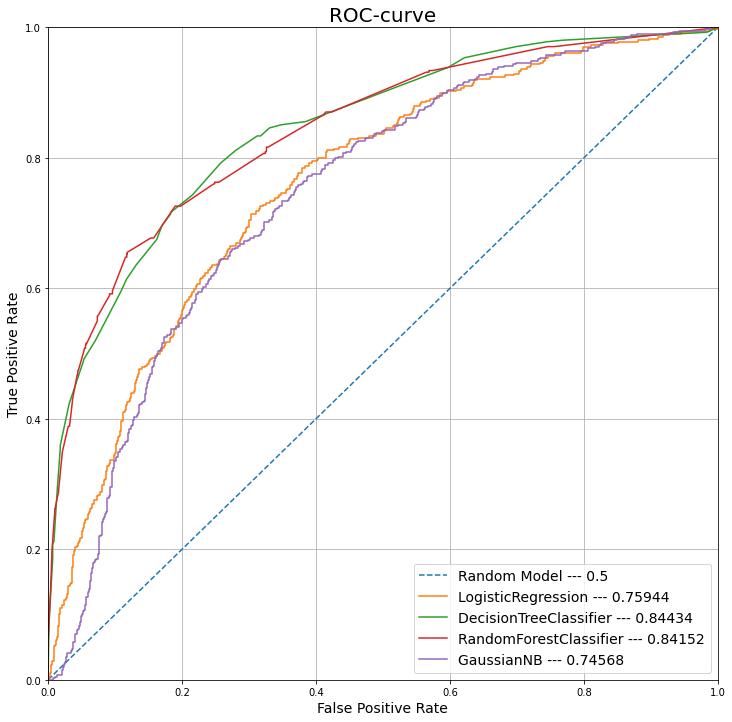

In [29]:
plot_roc_curves()

**Результаты:**
* Заметный рост $F1$-меры и $AUC-ROC$ у `Логистической регрессии`;
* Незначительный рост (в тысячных долях) по тем же метрикам у `Дерева решений`;
* Падение в сотых долях у `Случайного леса`.

**`Upsampling`**

In [30]:
def upsampling(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=271828
    )
    return features_upsampled, target_upsampled

In [31]:
features_upsampled, target_upsampled = upsampling(features_train, target_train, 4)

target_value_counts = target_upsampled.value_counts()
print('Распределение классов порядка 1 к {:.0f}.'.format(target_value_counts[0] / target_value_counts[1]))

Распределение классов порядка 1 к 1.


In [32]:
for model in [logreg, tree_clf, rf_clf, bayes]:
    model.fit(features_upsampled, target_upsampled)

In [33]:
table = [
    [
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC'
    ],
    [
        'LogisticRegression', *get_model_metrics(logreg)
    ],
    [
        'DecisionTreeClassifier', *get_model_metrics(tree_clf)
    ],
    [
        'RandomForestClassifier', *get_model_metrics(rf_clf)
    ],
    [
        'GaussianNB', *get_model_metrics(bayes)
    ],
]

In [34]:
print_table(table)

                    Model   Accuracy   Precision   Recall       F1   AUC-ROC
       LogisticRegression      0.703      0.3762    0.687   0.4862    0.7595
   DecisionTreeClassifier      0.796      0.5009   0.7164   0.5895    0.8462
   RandomForestClassifier      0.842      0.6247   0.5697   0.5959    0.8519
               GaussianNB      0.708       0.378   0.6626   0.4813    0.7459


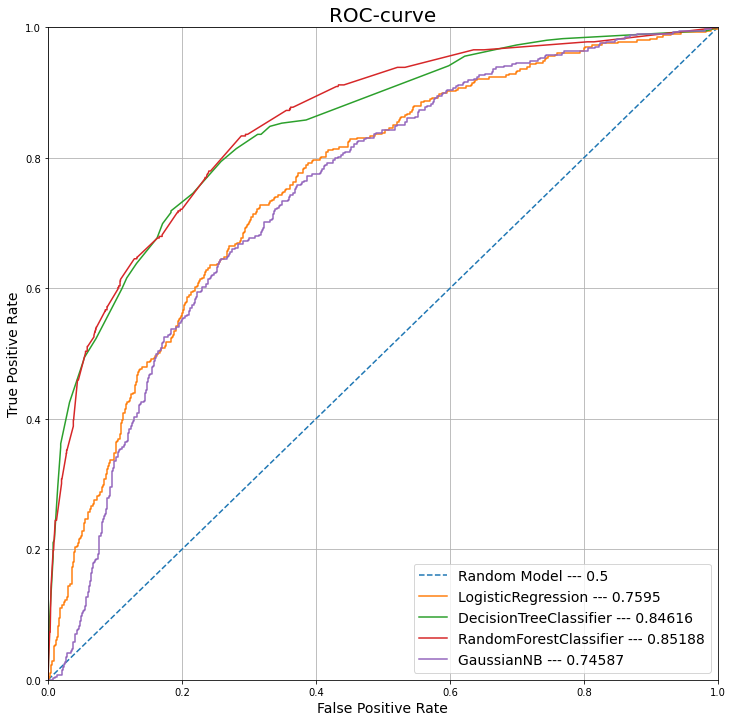

In [35]:
plot_roc_curves()

**Результаты:**
* В данном случае `Логистическая регрессия` также заметно возросла, однако для случая взвешенных классов результаты по $F1$-мере и $AUC-ROC$ были лучше.
* `Дерево решений` продолжило улучшаться в сравнении со взвешенными классами;
* Для `Случайного леса` ничего не изменилось - снова падения по мерам в пределах десятых долей для площади под $ROC$-кривой, однако лучшее значение $F1$-меры из всех случаев;
* `Наивный Байес` напротив. Не изменив практически значений по $AUC-ROC$ значительно вырос по $F1$-мере.
* `Случайный лес` продолжает оставаться наилучшей моделью из всех представленных в данной задаче.

**`Downsampling`**

In [36]:
def downsampling(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=271828)] + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=271828)] + [target_ones]
    )
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=271828
    )
    return features_downsampled, target_downsampled

In [37]:
features_downsampled, target_downsampled = downsampling(features_train, target_train, 0.258)

target_downsampled.value_counts()
# print('Распределение классов порядка 1 к {:.0f}.'.format(target_value_counts[0] / target_value_counts[1]))

0    1231
1    1229
Name: Exited, dtype: int64

In [38]:
for model in [logreg, tree_clf, rf_clf, bayes]:
    model.fit(features_downsampled, target_downsampled)

In [39]:
table = [
    [
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC'
    ],
    [
        'LogisticRegression', *get_model_metrics(logreg)
    ],
    [
        'DecisionTreeClassifier', *get_model_metrics(tree_clf)
    ],
    [
        'RandomForestClassifier', *get_model_metrics(rf_clf)
    ],
    [
        'GaussianNB', *get_model_metrics(bayes)
    ],
]

In [40]:
print_table(table)

                    Model   Accuracy   Precision   Recall       F1   AUC-ROC
       LogisticRegression     0.7045      0.3774   0.6846   0.4865    0.7564
   DecisionTreeClassifier      0.761      0.4476   0.7213   0.5524    0.8314
   RandomForestClassifier     0.7695      0.4607   0.7457   0.5696    0.8418
               GaussianNB       0.71      0.3784   0.6504   0.4784    0.7469


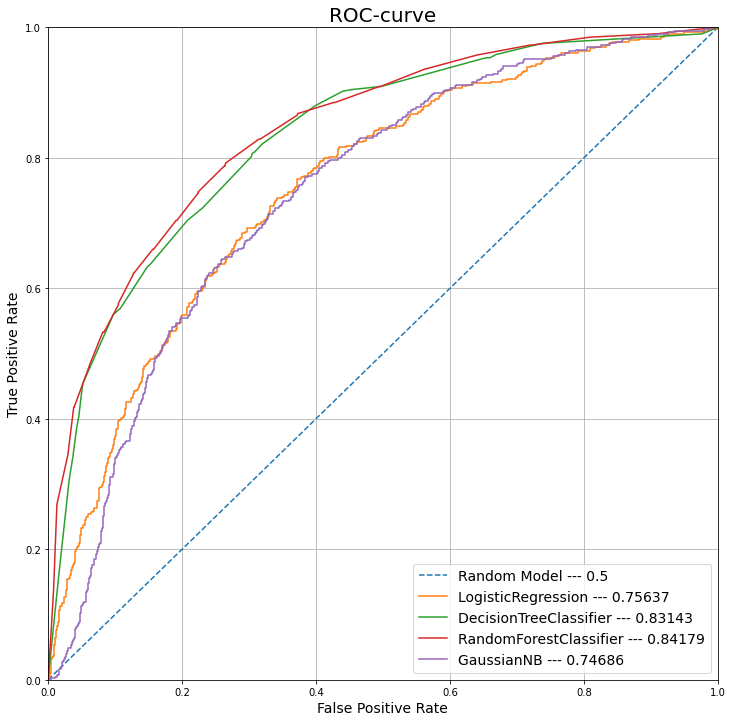

In [41]:
plot_roc_curves()

**Результаты:**
* Лучший результат для `Логистической регрессии` и `Наивного Байеса`;
* Снова падение в десятых долях как для `Дерева решений`, так и для `Случайного леса`.

**Выводы:**
1. Дисбаланс классов влиял на модели в худшую сторону. Наилучшим решением считаем `upsampling` классов.
2. Выберем в качестве тестовой модели `Случайный лес`.
____

<a id='section4'></a>
## 4. Тестирование модели

План тестирования:
1. Продолжим перебор гиперпараметров с целью увеличения $F1$-меры, а именно:
    * n_estimators;
    * max_depth;
    * min_samples_split;
    * min_samples_leaf;
2. Проверим уже на улучшенной модели площадь под $ROC$-кривой на тестовой выборке для
    * Дисбалансных классов;
    * Взвешенных классов;
    * Upsampling;
    * Downsampling.

In [42]:
%%time

best_est, best_depth, best_split, best_leaf, best_f1 = 0, 0, 0, 0, 0
for est in tqdm(range(5, 25, 5)):
    # Сразу начнём с глубины 5.
    for depth in range(5, 21):
        for split in range(3, 11):
            for leaf in range(1, 11):
                rf_clf = RandomForestClassifier(
                    n_estimators=est, 
                    max_depth=depth, 
                    min_samples_split = split,
                    min_samples_leaf = leaf,
                    random_state=271828
                )
                rf_clf.fit(features_train, target_train)
                predicted_valid = rf_clf.predict(features_valid)
                tmp_f1 = f1_score(target_valid, predicted_valid)
                if best_f1 < tmp_f1:
                    best_est = est
                    best_depth = depth
                    best_split = split
                    best_leaf = leaf
                    best_f1 = tmp_f1
                    print(
                        'n_estimators = {:.0f} | max_depth = {:.0f} | min_samples_split = {:.0f} | min_samples_leaf = {:.0f} | F1-мера ='
                        .format(best_est, best_depth, best_split, best_leaf), 
                        best_f1
                    )
rf_clf = RandomForestClassifier(
    n_estimators = best_est,
    max_depth = best_depth,
    min_samples_split = best_split,
    min_samples_leaf = best_leaf,
    random_state = 271828
)


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

n_estimators = 5 | max_depth = 5 | min_samples_split = 3 | min_samples_leaf = 1 | F1-мера = 0.511864406779661
n_estimators = 5 | max_depth = 5 | min_samples_split = 3 | min_samples_leaf = 4 | F1-мера = 0.5194805194805195
n_estimators = 5 | max_depth = 5 | min_samples_split = 10 | min_samples_leaf = 4 | F1-мера = 0.5224358974358975
n_estimators = 5 | max_depth = 6 | min_samples_split = 3 | min_samples_leaf = 1 | F1-мера = 0.5324675324675324
n_estimators = 5 | max_depth = 6 | min_samples_split = 3 | min_samples_leaf = 3 | F1-мера = 0.5327102803738317
n_estimators = 5 | max_depth = 6 | min_samples_split = 5 | min_samples_leaf = 1 | F1-мера = 0.5451713395638629
n_estimators = 5 | max_depth = 6 | min_samples_split = 6 | min_samples_leaf = 1 | F1-мера = 0.5471698113207547
n_estimators = 5 | max_depth = 6 | min_samples_split = 6 | min_samples_leaf = 2 | F1-мера = 0.5511811023622047
n_estimators = 5 | max_depth = 7 | min_samples_split = 3 | min_samples_leaf = 4 | F1-мера = 0.5583596214511041
n

 25%|█████████████████████                                                               | 1/4 [00:29<01:27, 29.30s/it]

n_estimators = 10 | max_depth = 12 | min_samples_split = 10 | min_samples_leaf = 2 | F1-мера = 0.603221083455344


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:24<00:00, 66.24s/it]

Wall time: 4min 24s


**Результат:**  

Максимальная $F1-мера = 0.60322$ получена при следующих значениях гиперпараметров:
    * n_estimators = 10;
    * max_depth = 12;
    * min_samples_split = 10;
    * min_samples_leaf = 2

Лучшая модель случайного леса при дисбалансе классов уже получена => `rf_clf`. Переобозначим через `rf_disbalanced`.

In [43]:
rf_disbalanced = rf_clf
rf_disbalanced.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=271828,
                       verbose=0, warm_start=False)

**`class_weight = 'balanced'`**

In [44]:
rf_balanced = RandomForestClassifier(
    n_estimators = best_est,
    max_depth = best_depth,
    min_samples_split = best_split,
    min_samples_leaf = best_leaf,
    random_state = 271828,
    class_weight = 'balanced'
)
rf_balanced.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=271828, verbose=0, warm_start=False)

**`Upsampling`**

In [45]:
rf_upsampled = RandomForestClassifier(
    n_estimators = best_est,
    max_depth = best_depth,
    min_samples_split = best_split,
    min_samples_leaf = best_leaf,
    random_state = 271828,
)
rf_upsampled.fit(features_upsampled, target_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=271828,
                       verbose=0, warm_start=False)

**`Downsampling`**

In [46]:
rf_downsampled = RandomForestClassifier(
    n_estimators = best_est,
    max_depth = best_depth,
    min_samples_split = best_split,
    min_samples_leaf = best_leaf,
    random_state = 271828,
)
rf_downsampled.fit(features_downsampled, target_downsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=271828,
                       verbose=0, warm_start=False)

In [47]:
table = [
    [
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC'
    ],
    [
        'RandomForestClassifier - Disbalanced classes', *get_model_metrics(
            rf_disbalanced, 
            features = features_test,
            target = target_test
        )
    ],
    [
        'RandomForestClassifier - Balanced classes', *get_model_metrics(
            rf_balanced,
            features = features_test,
            target = target_test
        )
    ],
    [
        'RandomForestClassifier - Upsampled', *get_model_metrics(
            rf_upsampled,
            features = features_test,
            target = target_test
        )
    ],
    [
        'RandomForestClassifier - Downsampled', *get_model_metrics(
            rf_downsampled,
            features = features_test,
            target = target_test            
        )
    ],
]

In [48]:
print_table(table)

                                          Model   Accuracy   Precision   Recall       F1   AUC-ROC
   RandomForestClassifier - Disbalanced classes     0.8695      0.7828   0.4787   0.5941    0.8414
      RandomForestClassifier - Balanced classes      0.839      0.5965   0.5965   0.5965    0.8329
             RandomForestClassifier - Upsampled      0.834      0.5753   0.6416   0.6066    0.8454
           RandomForestClassifier - Downsampled      0.787      0.4775   0.7193    0.574    0.8474


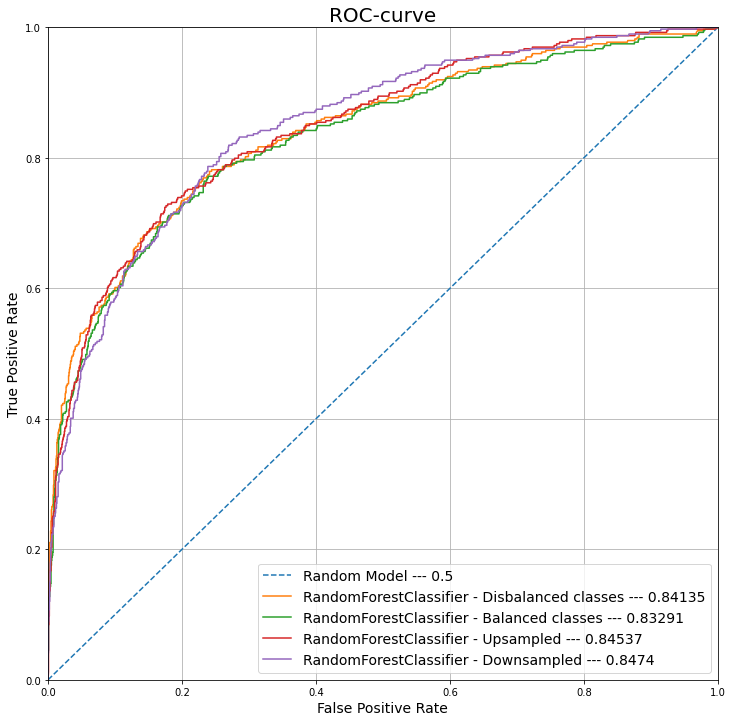

In [49]:
plt.figure(figsize=[12, 12])
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--', label='Random Model' + ' --- ' + str(0.5))
models_dict = {
    'RandomForestClassifier - Disbalanced classes' : rf_disbalanced, 
    'RandomForestClassifier - Balanced classes' : rf_balanced,
    'RandomForestClassifier - Upsampled' : rf_upsampled, 
    'RandomForestClassifier - Downsampled' : rf_downsampled
}
for name, model in models_dict.items():
    probabilities_one_test = model.predict_proba(features_test)[:, 1]
    fpr, tpr, threshold = roc_curve(target_test, probabilities_one_test)
    auc_roc = np.round(roc_auc_score(target_test, probabilities_one_test), 5)
    plt.plot(fpr, tpr, label=name + ' --- ' + str(auc_roc))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc=4, fontsize=14)
plt.grid()
plt.title('ROC-curve', fontsize=20)
plt.show()

**Выводы:**
* В результате рассмотрения сбалансированных и дисбаланстных классов наилучший результат по $F1$-мере показала модель `Случайный лес: увеличение класса "1"`. Эта модель имеет второй показатель по площади $ROC$-кривой, отставая от `Случайный лес: уменьшения класса "0"`.
* В силу вышесказанного выбираем модель `Случайный лес: увеличение класса "1"`.

<a id='section6'></a>
## 6. Выводы исследования

1. **Предобработка:**
    1. Строки со значениями `Nan` в столбце `Tenure` были классифицированы как отсутствие недвижимости у клиента и заполнены нулями;
    2. Удалены столбцы `RowNumber`, `CustomerId`, `Surname`, т.к. не несут информации для построения модели классификации по поставленной задаче;
    3. Оставшиеся категориальные признаки были переведены в количественные по средствам метода прямого кодирования с защитой от дамми-ловушки.
2. **Исследование задачи:**
    1. Лучшие метрики по $F1$-мере и $AUC-ROC$ получены у модели `Случайного леса`.
    2. Все обученные модели, вследствие дисбаланса классов, имеют меньшие значения по полноте относительно точности. 
    3. В данных есть дисбаланс классов в соотношении порядка $1$ к $4$.
3. **Борьба с дисбалансом:**
    1. Дисбаланс классов влиял на модели в худшую сторону. Наилучшим решением считаем `upsampling` классов.
    2. Выберем в качестве тестовой модели `Случайный лес`.
4. **Тестирование модели:**
    1. В результате рассмотрения сбалансированных и дисбаланстных классов наилучший результат по $F1$-мере показала модель `Случайный лес: увеличение класса "1"`. Эта модель имеет второй показатель по площади $ROC$-кривой, отставая от `Случайный лес: уменьшения класса "0"`. Что подтверждает результат полученный в главе 3 исследования (`Борьба с дисбалансом`)
    2. В силу вышесказанного выбираем модель `Случайный лес: увеличение класса "1"` со следующими значениями метрик:
        * $Accuracy = 0.834$;
        * $Precision = 0.5753$;
        * $Recall = 0.6416$;   
        * $F1-мера = 0.6066$;
        * $AUC-ROC = 0.8454$.